<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45267 entries, 2017-10-17 10:00:00 to 2022-12-16 12:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    45267 non-null  float32
 1   pm10    45267 non-null  float32
 2   no2     45267 non-null  float32
 3   so2     45267 non-null  float32
 4   co      45267 non-null  float32
 5   o3      45267 non-null  float32
dtypes: float32(6)
memory usage: 1.4 MB


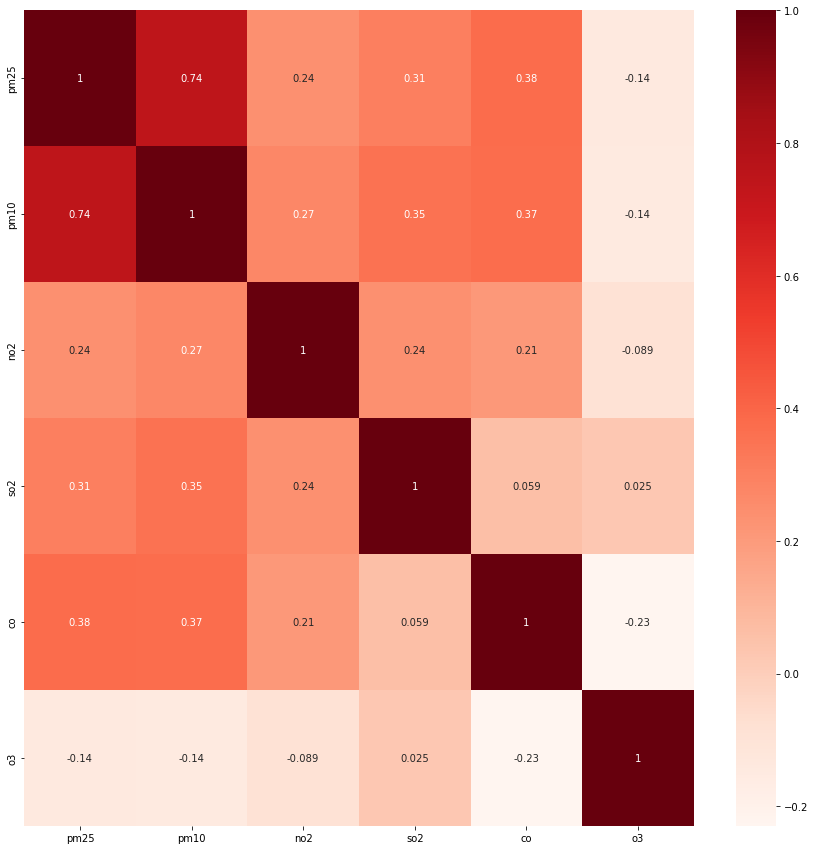

features: (45267, 6)
targets: (45267, 6)
X_train: (36666, 6)
X_test: (4527, 6)
X_val: (4074, 6)
y_train: (36666, 6)
y_test: (4527, 6)
y_val: (4074, 6)


((36666, 6), (4527, 6))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import data using datetime and set index to datetime
df = pd.read_csv(r'D:\aa\working_results\Book3.CSV',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()
 
df = df.astype(np.float32)
df.info()

import seaborn as sns
plt.figure(figsize=(15,15))
cor = df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


dataset = df.copy()
dataset

from sklearn.model_selection import train_test_split

features=df.values
targets=df[["pm25", "pm10", "no2", "o3", "so2","co"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("features:", features.shape)
print("targets:", targets.shape)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)

print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_val:", y_val.shape)


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

In [2]:
win_length=6
batch_size=4
num_features=features.shape[1]  #num_features=12

In [3]:
from tensorflow import keras
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation="relu",
        )
    )
    model.add(layers.Dense(6, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
    )
    return model

In [4]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

In [5]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [6]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [7]:
tuner.search(X_train, y_train, epochs=4,validation_data=(X_train, y_train))
#tuner.search(X_train.values, y_train.values, epochs=2, validation_data=(X_train, y_train))

Trial 3 Complete [00h 00m 22s]
val_accuracy: 0.9646811485290527

Best val_accuracy So Far: 0.9646811485290527
Total elapsed time: 00h 01m 10s
INFO:tensorflow:Oracle triggered exit


In [8]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

In [9]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [10]:
hp = keras_tuner.HyperParameters()
print(hp.Int("units", min_value=32, max_value=512, step=32))

32


In [18]:
def call_existing_code(units, activation, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(6, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model


build_model(keras_tuner.HyperParameters())

In [23]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(6, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [24]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [26]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Trial 3 Complete [00h 00m 13s]
val_accuracy: 0.9825724363327026

Best val_accuracy So Far: 0.9825724363327026
Total elapsed time: 00h 00m 34s
INFO:tensorflow:Oracle triggered exit


In [27]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

ValueError: In this `tf.Variable` creation, the initial value's shape ((6, 448)) is not compatible with the explicitly supplied `shape` argument ((784, 448)).

In [ ]:
tuner.results_summary()

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x=x_all, y=y_all, epochs=1)

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )

In [ ]:
hp = keras_tuner.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(layers.Dense(10, activation="softmax"))
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, x, y, **kwargs):
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )


hp = keras_tuner.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        image_size = hp.Int("image_size", 10, 28)
        inputs = keras.Input(shape=(image_size, image_size))
        outputs = layers.Flatten()(inputs)
        outputs = layers.Dense(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation="relu",
        )(outputs)
        outputs = layers.Dense(10, activation="softmax")(outputs)
        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, x, y, validation_data=None, **kwargs):
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        image_size = hp.get("image_size")
        cropped_x = x[:, :image_size, :image_size, :]
        if validation_data:
            x_val, y_val = validation_data
            cropped_x_val = x_val[:, :image_size, :image_size, :]
            validation_data = (cropped_x_val, y_val)
        return model.fit(
            cropped_x,
            y,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            validation_data=validation_data,
            **kwargs,
        )


tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))

In [ ]:
hypermodel = MyHyperModel()
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)
hypermodel.fit(best_hp, model, x_all, y_all, epochs=1)

In [ ]:
def build_regressor(hp):
    model = keras.Sequential(
        [
            layers.Dense(units=hp.Int("units", 32, 128, 32), activation="relu"),
            layers.Dense(units=1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        # Objective is one of the metrics.
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return model


tuner = keras_tuner.RandomSearch(
    hypermodel=build_regressor,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="built_in_metrics",
)

tuner.search(
    x=np.random.rand(100, 10),
    y=np.random.rand(100, 1),
    validation_data=(np.random.rand(20, 10), np.random.rand(20, 1)),
)

tuner.results_summary()

In [ ]:
import tensorflow as tf


class CustomMetric(keras.metrics.Metric):
    def __init__(self, **kwargs):
        # Specify the name of the metric as "custom_metric".
        super().__init__(name="custom_metric", **kwargs)
        self.sum = self.add_weight(name="sum", initializer="zeros")
        self.count = self.add_weight(name="count", dtype=tf.int32, initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.math.squared_difference(y_pred, y_true)
        count = tf.shape(y_true)[0]
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            values *= sample_weight
            count *= sample_weight
        self.sum.assign_add(tf.reduce_sum(values))
        self.count.assign_add(count)

    def result(self):
        return self.sum / tf.cast(self.count, tf.float32)

    def reset_states(self):
        self.sum.assign(0)
        self.count.assign(0)

In [ ]:
def build_regressor(hp):
    model = keras.Sequential(
        [
            layers.Dense(units=hp.Int("units", 32, 128, 32), activation="relu"),
            layers.Dense(units=1),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        # Put custom metric into the metrics.
        metrics=[CustomMetric()],
    )
    return model


tuner = keras_tuner.RandomSearch(
    hypermodel=build_regressor,
    # Specify the name and direction of the objective.
    objective=keras_tuner.Objective("val_custom_metric", direction="min"),
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="custom_metrics",
)

tuner.search(
    x=np.random.rand(100, 10),
    y=np.random.rand(100, 1),
    validation_data=(np.random.rand(20, 10), np.random.rand(20, 1)),
)

tuner.results_summary()

In [ ]:
class HyperRegressor(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential(
            [
                layers.Dense(units=hp.Int("units", 32, 128, 32), activation="relu"),
                layers.Dense(units=1),
            ]
        )
        model.compile(
            optimizer="adam", loss="mean_squared_error",
        )
        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        model.fit(x, y, **kwargs)
        x_val, y_val = validation_data
        y_pred = model.predict(x_val)
        # Return a single float to minimize.
        return np.mean(np.abs(y_pred - y_val))


tuner = keras_tuner.RandomSearch(
    hypermodel=HyperRegressor(),
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="custom_eval",
)
tuner.search(
    x=np.random.rand(100, 10),
    y=np.random.rand(100, 1),
    validation_data=(np.random.rand(20, 10), np.random.rand(20, 1)),
)

tuner.results_summary()

In [ ]:
class HyperRegressor(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential(
            [
                layers.Dense(units=hp.Int("units", 32, 128, 32), activation="relu"),
                layers.Dense(units=1),
            ]
        )
        model.compile(
            optimizer="adam", loss="mean_squared_error",
        )
        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        model.fit(x, y, **kwargs)
        x_val, y_val = validation_data
        y_pred = model.predict(x_val)
        # Return a dictionary of metrics for KerasTuner to track.
        return {
            "metric_a": -np.mean(np.abs(y_pred - y_val)),
            "metric_b": np.mean(np.square(y_pred - y_val)),
        }


tuner = keras_tuner.RandomSearch(
    hypermodel=HyperRegressor(),
    # Objective is one of the keys.
    # Maximize the negative MAE, equivalent to minimize MAE.
    objective=keras_tuner.Objective("metric_a", "max"),
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="custom_eval_dict",
)
tuner.search(
    x=np.random.rand(100, 10),
    y=np.random.rand(100, 1),
    validation_data=(np.random.rand(20, 10), np.random.rand(20, 1)),
)

tuner.results_summary()

In [ ]:
class MyTuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # Get the hp from trial.
        hp = trial.hyperparameters
        # Define "x" as a hyperparameter.
        x = hp.Float("x", min_value=-1.0, max_value=1.0)
        # Return the objective value to minimize.
        return x * x + 1


tuner = MyTuner(
    # No hypermodel or objective specified.
    max_trials=20,
    overwrite=True,
    directory="my_dir",
    project_name="tune_anything",
)

# No need to pass anything to search()
# unless you use them in run_trial().
tuner.search()
print(tuner.get_best_hyperparameters()[0].get("x"))

In [ ]:
import os


def keras_code(units, optimizer, saving_path):
    # Build model
    model = keras.Sequential(
        [layers.Dense(units=units, activation="relu"), layers.Dense(units=1),]
    )
    model.compile(
        optimizer=optimizer, loss="mean_squared_error",
    )

    # Prepare data
    x_train = np.random.rand(100, 10)
    y_train = np.random.rand(100, 1)
    x_val = np.random.rand(20, 10)
    y_val = np.random.rand(20, 1)

    # Train & eval model
    model.fit(x_train, y_train)

    # Save model
    model.save(saving_path)

    # Return a single float as the objective value.
    # You may also return a dictionary
    # of {metric_name: metric_value}.
    y_pred = model.predict(x_val)
    return np.mean(np.abs(y_pred - y_val))


class MyTuner(keras_tuner.RandomSearch):
    def run_trial(self, trial, **kwargs):
        hp = trial.hyperparameters
        return keras_code(
            units=hp.Int("units", 32, 128, 32),
            optimizer=hp.Choice("optimizer", ["adam", "adadelta"]),
            saving_path=os.path.join("/tmp", trial.trial_id),
        )


tuner = MyTuner(
    max_trials=3, overwrite=True, directory="my_dir", project_name="keep_code_separate",
)
tuner.search()
# Retraining the model
best_hp = tuner.get_best_hyperparameters()[0]
keras_code(**best_hp.values, saving_path="/tmp/best_model")

In [ ]:
from keras_tuner.applications import HyperResNet

hypermodel = HyperResNet(input_shape=(28, 28, 1), classes=10)

tuner = keras_tuner.RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=2,
    overwrite=True,
    directory="my_dir",
    project_name="built_in_hypermodel",
)

tuner.search(
    x_train[:100], y_train[:100], epochs=1, validation_data=(x_val[:100], y_val[:100])
)